<div class="alert alert-block alert-success">
<br>
<font size = "+6", color = 'black'> <center> Converting RMM into Phase and Amplitude </center></font>
<br>

<font color = 'black'> <center> Previously we had just RMM1 and RMM2, no phase or amplitudee </center></font>

</div>

In [1]:

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import pickle
import matplotlib.colors as colors
import datetime as dt
import pickle
from matplotlib.colors import BoundaryNorm
import glob
import pdb

'''Jupyter Markdown Cheat Sheet'''
# https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
# https://www.ibm.com/support/knowledgecenter/en/SSGNPV_1.1.3/dsx/markd-jupyter.html

'Jupyter Markdown Cheat Sheet'

In [2]:
directory = '/g/data/w40/ab2313/RMM/'

In [3]:
'''The RMM from ACCESS-S that I have pieced together in the file: RMM_ACCESS-S'''
rmm_access_raw = xr.open_dataset(directory + 'rmm_access_raw.nc')
rmm_access_raw

<xarray.Dataset>
Dimensions:   (ensemble: 12, time: 8401)
Coordinates:
  * time      (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2012-12-31
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    rmm1      (ensemble, time) float32 ...
    rmm2      (ensemble, time) float32 ...

In [4]:
test = rmm_access_raw.isel(ensemble = 1, time =100)
rmm1 = test.rmm1.values
rmm2 = test.rmm2.values
print(rmm1, rmm2, sep = ' : ')

-0.33021247 : -0.97966236


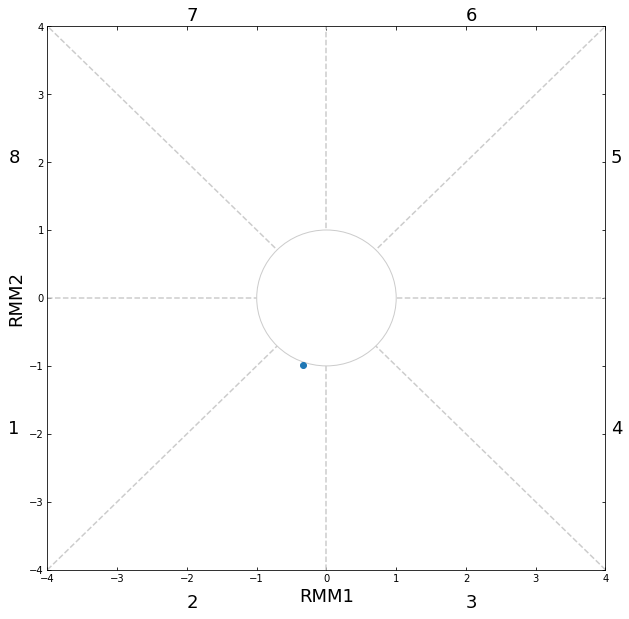

In [5]:
'''~~~~~~~~~~~~~~ The Plot'''
f, ax = plt.subplots(figsize=(10,10))



ax.set_xlim(-4,4)
ax.set_ylim(-4,4)
# ax.xaxis.set_minor_locator(MultipleLocator(0.5)) # Minor locators
# ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax.plot([-4,4],[-4,4], color='.8', ls='--') # THe dashed diagonal lines that define the phase
ax.plot([4, -4],[-4,4], color='.8', ls='--')
ax.axhline(0, color='.8', ls='--')
ax.axvline(0, color='.8', ls='--')
circ = plt.Circle((0, 0), radius=1, edgecolor='0.8', facecolor='w', zorder=3) # Circle. zorder = 3 to be over 
ax.add_patch(circ)                                                            # the dashed lines



'''~~~~~~~~~~~~~~ X and Y label'''

ax.set_ylabel('RMM2', fontsize=18.)
ax.set_xlabel('RMM1', fontsize=18.)


'''~~~~~~~~~~~~~~ Annotation the phase'''
ax.annotate('5',xy = (1.01,0.75), fontsize= 18, xycoords = 'axes fraction');
ax.annotate('6',xy = (0.75,1.01), fontsize= 18, xycoords = 'axes fraction');
ax.annotate('7',xy = (0.25,1.01), fontsize= 18, xycoords = 'axes fraction');
ax.annotate('8',xy = (-0.07,0.75), fontsize= 18, xycoords = 'axes fraction');
ax.annotate('1',xy = (-0.07,0.25), fontsize= 18, xycoords = 'axes fraction');
ax.annotate('2',xy = (0.25,-0.07), fontsize= 18, xycoords = 'axes fraction');
ax.annotate('3',xy = (0.75,-0.07), fontsize= 18, xycoords = 'axes fraction');
ax.annotate('4',xy = (1.01,0.25), fontsize= 18, xycoords = 'axes fraction');


plt.plot(rmm1,rmm2, marker = 'o', zorder = 100)

In [6]:
np.arctan2(rmm1, rmm2)* (180.0/ np.pi)

-161.3726994441192

In [7]:
np.arctan2(rmm2, rmm1)* (180.0/ np.pi) # This is the formula that you want!!!!!

-108.62729440893695

In [12]:
phase_ensemble = []
amp_ensemble = []
ensembles = rmm_access_raw.ensemble

for ensemble in ensembles:
    single = rmm_access_raw.sel(ensemble = ensemble)
    rmm2 = single.rmm2
    rmm1 = single.rmm1
    angle = np.arctan2(rmm2,rmm1) * (180.0/ np.pi)
    phase = np.array(angle.values)
    phase = np.where(np.logical_and(phase >= 0, phase< 45), 5, phase)
    phase = np.where(np.logical_and(phase >= 45, phase < 90), 6, phase)
    phase = np.where(np.logical_and(phase >= 90, phase < 135), 7, phase)
    phase = np.where(np.logical_and(phase >= 135, phase < 180), 8, phase)
    phase = np.where(np.logical_and(phase >= -180, phase < -135), 1, phase)
    phase = np.where(np.logical_and(phase >= -135, phase < -90), 2, phase)
    phase = np.where(np.logical_and(phase >= -90, phase < -45), 3, phase)
    phase = np.where(np.logical_and(phase >= -45, phase < 0), 4, phase)

    phase_ensemble.append(phase)
    
    amp = np.sqrt(single.rmm2 **2 + single.rmm1 **2)
    amp_ensemble.append(amp)

In [13]:
'''6. Making into an xarray file'''
rmm_access = xr.Dataset(
{'phase':(('ensemble','time'), phase_ensemble), 'amplitude':(('ensemble','time'), amp_ensemble)},
{'ensemble': np.arange(12),
 'time': rmm_access_raw.time.values})

In [14]:
rmm_access.attrs = {'Info':'this is the 3rd version with atan2(rmm2, rmm2) (with no + 180)'}

In [16]:
rmm_access.to_netcdf(directory + 'rmm_access_4.nc')